# 1D Stellar wind

---

In this example, we consider a simple spherically symmetric stellar wind model.
We use numpy and astropy to conveniently define the model parameters.

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
from astropy import units, constants

---

## Model setup

---

### Geometry
The model box is given by the radial coordinate $r \in [r_{\star}, r_{\text{out}}] = [1, 10^{4}] \ \text{au}$. The model is discretised on a logarithmically-spaced grid consisting of 1024 elements with $r \in [r_{\text{in}}, r_{\text{out}}] = [10^{-1}, 10^{4}] \ \text{au}$.
Note that $r_{\text{in}} < r_{\star}$, such that several rays hit the stellar surface, since, for concenience, we use the same discretisation for the impact parameters of the rays. We impose a boundary condition at $r=r_{\star}$, such that the part of the model inside the star ($r<r_{\star}$) does not contribute to the resulting observation, and thus cannot be reconstructed.

In [2]:
n_elements = 1024

r_in   = (1.0e-1 * units.au).si.value
r_out  = (1.0e+4 * units.au).si.value
r_star = (1.0e+0 * units.au).si.value

rs = np.logspace(np.log10(r_in), np.log10(r_out), n_elements, dtype=np.float64)

---

### Velocity
For the velocity field, we assume a typical radially outward directed $\beta$-law,
\begin{equation*}
v(r) \ = \ v_{\star} \ + \ \left( v_{\infty} - v_{\star} \right) \left(1 - \frac{r_{\star}}{r}\right)^{\beta} ,
\end{equation*}
in which $v_{0} = 0.1 \ \text{km}/ \text{s}$,  $v_{\infty} = 20 \ \text{km}/ \text{s}$, and $\beta=0.5$.

In [3]:
v_in  = (1.0e-1 * units.km / units.s).si.value
v_inf = (2.0e+1 * units.km / units.s).si.value
beta  = 0.5

v = np.empty_like(rs)
v[rs <= r_star] = 0.01
v[rs >  r_star] = v_in + (v_inf - v_in) * (1.0 - r_star / rs[rs > r_star])**beta

---

### Density
We assume the density and velocity to be related through the conservation of mass, such that,
\begin{equation*}
\rho \left( r \right) \ = \ \frac{\dot{M}}{4 \pi r^{2} \, v(r)},
\end{equation*}
where, for the mass-loss rate, we take a typical value of $\dot{M} = 5.0 \times 10^{-6} \ M_{\odot} / \text{yr}$.

In [4]:
Mdot = (3.0e-6 * units.M_sun / units.yr).si.value

rho  = Mdot / (4.0 * np.pi * rs**2 * v)

---

### CO abundance
The CO abundance is assumed to be proportional to the density, such that, $n^{\text{CO}}(r) = 3.0 \times 10^{-4} \, N_{A} \, \rho(r) / m^{\text{H}_2}$, with $N_{A}$ Avogadro's number, and $m^{\text{H}_2} = 2.02 \ \text{g}/\text{mol}$, the molar mass of $\text{H}_{2}$.

In [5]:
n_CO             = (3.0e-4 * constants.N_A.si.value / 2.02e-3) * rho
n_CO[rs<=r_star] = n_CO[n_CO<np.inf].max() # Set to max inside star

---

### Temperature
For the gas temperature, we assume a power law,
\begin{equation*}
T(r) \ = \ T_{\star} \left(\frac{r_{\star}}{r}\right)^{\epsilon} ,
\end{equation*}
with $T_{\star} = 2500 \ \text{K}$, and $\epsilon=0.6$.

In [6]:
T_star = (2.5e+3 * units.K).si.value
epsilon = 0.6

T = np.empty_like(rs)
T[rs <= r_star] = T_star
T[rs >  r_star] = T_star * (r_star / rs[rs > r_star])**epsilon

---

### Micro-turbulence
Finally, we assume a constant turbulent velocity $v_{\text{turb}}(r) = 1 \ \text{km}/\text{s}$.

In [7]:
v_turb = (1.0e+0 * units.km / units.s).si.value

---

### TensorModel
With all the data in place, we can start building a pomme model.
First, we store all model parameters as a TensorModel object and store this in an HDF5 file.
We will use this later as the ground truth to verify our reconstructions against.

In [8]:
from pomme.model import TensorModel

model = TensorModel(sizes=r_out, shape=n_elements)
model['log_r'         ] = np.log(rs)
model['log_CO'        ] = np.log(n_CO)
model['log_turbulence'] = np.log(v_turb)
model['log_v_in'      ] = np.log(v_in)
model['log_v_inf'     ] = np.log(v_inf)
model['log_beta'      ] = np.log(beta)
model['log_epsilon'   ] = np.log(epsilon)
model['log_T_star'    ] = np.log(T_star)
model['log_r_star'    ] = np.log(r_star)
model.save('1D_stellar_wind_truth.h5')

---

### SphericalModel
First, we define the functions that can generate the model distributions from the model parameters.

In [9]:
import torch
from pomme.utils import planck, T_CMB

def get_velocity(model):
    """
    Get the velocity from the TensorModel.
    """
    # Extract parameters
    r      = torch.exp(model['log_r'])
    v_in   = torch.exp(model['log_v_in'])
    v_inf  = torch.exp(model['log_v_inf'])
    beta   = torch.exp(model['log_beta'])
    R_star = torch.exp(model['log_r_star'])
    # Compute velocity
    v = torch.empty_like(r)
    v[r <= r_star] = v_in
    v[r >  r_star] = v_in + (v_inf - v_in) * (1.0 - r_star / r[r > r_star])**beta
    # Return
    return v

def get_temperature(model):
    """
    Get the temperature from the TensorModel.
    """
    # Extract parameters
    r       = torch.exp(model['log_r'])
    T_star  = torch.exp(model['log_T_star'])
    epsilon = torch.exp(model['log_epsilon'])
    r_star  = torch.exp(model['log_r_star'])
    # Compute temperature
    T = torch.empty_like(r)    
    T[r <= r_star] = T_star
    T[r >  r_star] = T_star * (r_star / r[r > r_star])**epsilon
    # Return
    return T

def get_abundance(model):
    """
    Get the abundance from the TensorModel.
    """
    return torch.exp(model['log_CO'])

def get_turbulence(model):
    """
    Get the turbulence from the TensorModel.
    """
    return torch.exp(model['log_turbulence']) * torch.ones_like(model['log_r'])

def get_boundary_condition(model, frequency, b):
    """
    Get the boundary condition from the TensorModel.
    model: TensorModel
        The TensorModel object containing the model.
    frequency: float
        Frequency at which to evaluate the boundary condition.
    b: float
        Impact parameter of the line-of-sight in the spherical model.
    """
    # Extract parameters
    T_star = torch.exp(model['log_T_star'])
    r_star = torch.exp(model['log_r_star'])
    # Compute boundary condition
    if b > r_star:
        return planck(temperature=T_CMB, frequency=frequency)
    else:
        return planck(temperature=T_star, frequency=frequency)

Using these functions, we can build a SphericalModel object that can be used to generate synthetic observations or reconstruct the required parameters.
The SphericalModel class is a convenience class that can make the necessary transformations, e.g. for ray tracing in a spherically symmetric geometry.

In [10]:
from pomme.model import SphericalModel

smodel_truth = SphericalModel(rs, model, r_star=r_star)
smodel_truth.get_velocity           = get_velocity
smodel_truth.get_abundance          = get_abundance
smodel_truth.get_turbulence         = get_turbulence
smodel_truth.get_temperature        = get_temperature
smodel_truth.get_boundary_condition = get_boundary_condition

---

### Spectral lines
We base our reconstructions on synthetic observations of two commonly observed rotational CO lines $J = \{(3-2), \, (7-6)\}$.

In [11]:
from pomme.lines import Line

lines = [Line('CO', i) for i in [2, 6]]

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=7-6)
Please check the properties that were inferred:
    Frequency         8.066518060e+11  Hz
    Einstein A coeff  3.422000000e-05  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


---

### Frequencies
Next, we define the velocity/frequency range.
We observe the lines in 50 frequency bins, centred around the lines, with a spacing of 500 m/s.

In [12]:
vdiff = 500   # velocity increment size [m/s]
nfreq =  50   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq, dtype=torch.float64)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]

---

## Synthetic observations
We can now generate synthetic observations, directly from the SphericalModel object.
We will use these later to derive our reconstructions.

In [13]:
obss = smodel_truth.image(lines, frequencies, r_max=r_out)

Plot the resulting synthetic spectral line observations.

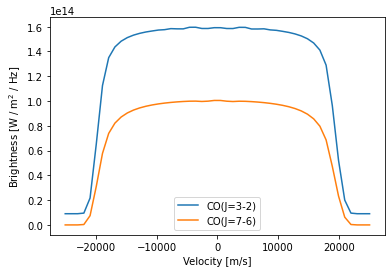

In [14]:
for line, obs in zip(lines, obss):
    plt.plot(velocities, obs, label=line.description)
plt.legend()
plt.xlabel('Velocity [m/s]')
plt.ylabel('Brightness [W / m$^2$ / Hz]')
plt.show()

---

## Reconstruction setup
In this example, we will try to reconstruct the CO abundance, velocity, and temperature distribution.
First, we define the model object for the reconstruction. Note that in the smodel defined above, all the right parameters are already stored, so we need a new one for the reconstruction.
We take, $n_{\text{CO}}^{\text{init}}(r) = 5.0 \times 10^{14} \, \text{m}^{-3} \, (r_{\text{in}}/r)^{2} $, as initial guess for the CO abundance distribution, and initialise both the velocity and the temperature with the correct values.

In [16]:
smodel_recon = SphericalModel(
    rs       = smodel_truth.rs,
    model_1D = smodel_truth.model_1D.deepcopy(),
    r_star   = smodel_truth.r_star,
)
smodel_recon.get_abundance          = lambda model: torch.exp(model['log_CO'])
smodel_recon.get_velocity           = lambda model: torch.exp(model['log_velocity'])
smodel_recon.get_temperature        = lambda model: torch.exp(model['log_temperature'])
smodel_recon.get_turbulence         = get_turbulence
smodel_recon.get_boundary_condition = get_boundary_condition

# Define initial guess for the CO abundance
n_CO_init = 5.0e+14 * (smodel_recon.rs.min()/smodel_recon.rs)**2

# Intialize model with the truth, except for the CO abundance
smodel_recon.model_1D['log_CO'         ] = np.log(n_CO_init).copy()
smodel_recon.model_1D['log_velocity'   ] = np.log(v        ).copy()
smodel_recon.model_1D['log_temperature'] = np.log(T        ).copy()

# Fix all parameters, except for the ones we want to fit
smodel_recon.model_1D.fix_all()
smodel_recon.model_1D.free(['log_CO', 'log_velocity', 'log_temperature'])

We can explore the model parameters with the info() function.

In [17]:
smodel_recon.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_r                      Fixed         True     +2.343e+01     +2.919e+01     +3.494e+01
  log_CO                     Free          True     +1.082e+01     +2.233e+01     +3.385e+01
  log_turbulence             Fixed         False    +6.908e+00     +6.908e+00     +6.908e+00
  log_v_in                   Fixed         False    +4.605e+00     +4.605e+00     +4.605e+00
  log_v_inf                  Fixed         False    +9.903e+00     +9.903e+00     +9.903e+00
  log_beta                   Fixed         False    -6.931e-01     -6.931e-01     -6.931e-01
  log_epsilon                Fixed         False    -5.108e-01     -5.108e-01     -5.108e-01
  log_T_star                 Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_r_star                 Fixed         False    +2.573e+01     +2.573e+01     +2.573e+01
  log_velocity               Free          True     -4.605e+00     +6.928e+00

Or, can plot them.

log_turbulence       6.907755278982137
log_v_in             4.605170185988092
log_v_inf            9.903487552536127
log_beta             -0.6931471805599453
log_epsilon          -0.5108256237659907
log_T_star           7.824046010856292
log_r_star           25.731216669096725


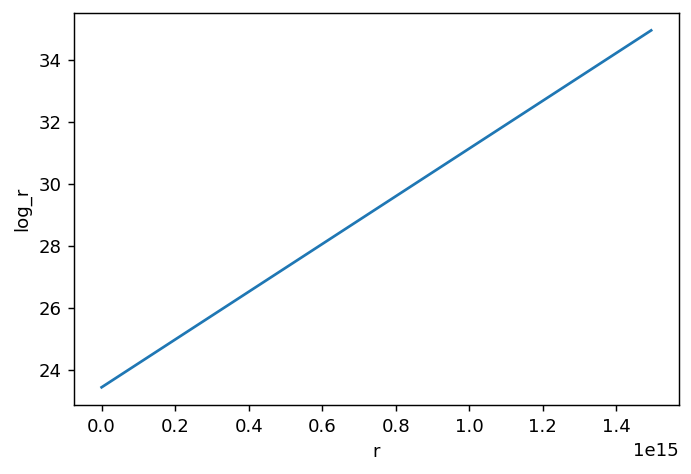

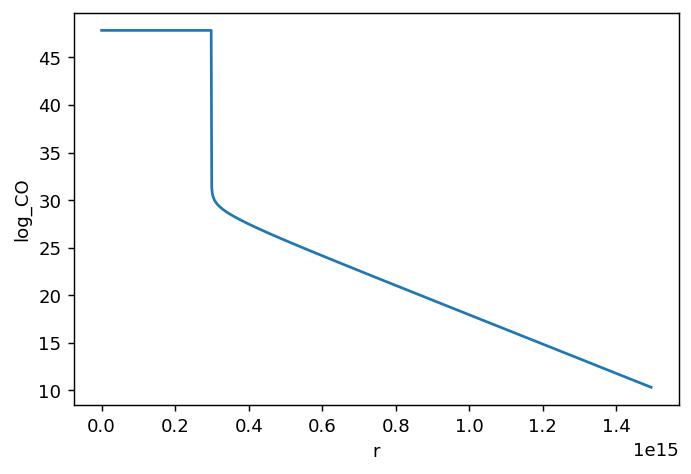

In [20]:
smodel_recon.plot()

---

### Loss functions
We first create Loss object that can conveniently store the different losses.
We will use a reproduction loss (split into an averaged and relative component), a smoothness, and a continuity loss.

In [16]:
from pomme.loss import Loss, diff_loss

losses = Loss(['avg', 'rel', 'smt', 'cnt'])

---

#### Reproduction loss
We split the reproduction loss into an averaged and a relative component,
\begin{equation*}
\mathcal{L}_{\text{rep}}\big(f(\boldsymbol{m}), \boldsymbol{o} \big)
\ = \
\mathcal{L}_{\text{rep}}\Big( \big\langle f(\boldsymbol{m}) \big\rangle, \, \left\langle\boldsymbol{o}\right\rangle \Big)
\ + \
\mathcal{L}_{\text{rep}}\left( \frac{f(\boldsymbol{m})}{\big\langle f(\boldsymbol{m})\big\rangle}, \, \frac{\boldsymbol{o}}{\left\langle \boldsymbol{o}\right\rangle} \right) ,
\end{equation*}

In [17]:
# Define averaging and relative function
avg = lambda arr: arr.mean(axis=1)
rel = lambda arr: torch.einsum("ij, i -> ij", arr, 1.0/avg(arr))

def avg_loss(smodel, imgs):
    """
    Compute the average loss.
    """
    return torch.nn.functional.mse_loss(avg(imgs), avg(obss))

def rel_loss(smodel, imgs):
    """
    Compute the relative loss.
    """
    return torch.nn.functional.mse_loss(rel(imgs), rel(obss))

---

#### Smoothness loss
The smoothnes loss in spherical symmetry is defined as, 
\begin{equation}
\mathcal{L}[q]
\ = \
\int_{0}^{\infty} 4 \pi r^{2} \text{d} r \ \big\{ \partial_{r} q(r) \big\}^{2}
\end{equation}

In [18]:
def smoothness_loss(smodel):
    """
    Smoothness loss for CO, velocity, and temperature distributions.
    """
    # Get a mask for the elements outsife the star
    outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_r_star'])
    # Compute and return the loss
    return (   diff_loss(smodel.model_1D['log_CO'         ][outside_star]) \
             + diff_loss(smodel.model_1D['log_velocity'   ][outside_star]) \
             + diff_loss(smodel.model_1D['log_temperature'][outside_star]) )

---

#### Continuity loss
In spherical symmetry, the regularisation loss that assumes a steady state and enforces the continuity equation, reads,
\begin{equation*}
\mathcal{L}[\rho, v]
\ = \
\int_{0}^{\infty} 4\pi r^{2} \text{d}r \left\{ \frac{1}{\rho \, r^{2}} \, \partial_{r} \left( r^{2} \rho \, v \right) \right\}^{2} .
\end{equation*}

In [19]:
def steady_state_cont_loss(smodel):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """
    # Get a mask for the elements outsife the star
    outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_r_star'])
    # Get the model variables
    rho = smodel.get_abundance(smodel.model_1D)[outside_star]
    v_r = smodel.get_velocity (smodel.model_1D)[outside_star]
    r   = torch.from_numpy(smodel.rs)          [outside_star]
    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = smodel.diff_r(r**2 * rho * v_r, r) / (rho*r**2)
    # Compute the mean squared losses
    loss = torch.mean(4.0*torch.pi*r**2*(loss_cont)**2)
    # Return losses
    return loss

---

### Fit function
With everything in place, we can finally define the fit function.

In [20]:
from torch.optim import Adam
from tqdm        import tqdm

def fit(losses, smodel, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0, w_smt=1.0, w_cnt=1.0):
    # Define optimiser
    optimizer = Adam(model.free_parameters(), lr=lr)
    # Iterate optimiser
    for _ in tqdm(range(N_epochs)):
        # Forward model
        imgs = smodel.image(lines, frequencies, r_max=r_out)
        # Compute the losses
        losses['avg'] = w_avg * avg_loss(smodel, imgs)
        losses['rel'] = w_rel * rel_loss(smodel, imgs)
        losses['smt'] = w_smt * smoothness_loss(smodel)
        losses['cnt'] = w_cnt * steady_state_cont_loss(smodel)
        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        losses.tot().backward()
        # Update parameters
        optimizer.step()
    # Return the images and losses
    return imgs, losses

---

## Experiments

In [21]:
imgs, losses = fit(losses, smodel_recon,
    N_epochs = 3,
    lr       = 1.0e-1,
    w_avg    = 1.0e+0,
    w_rel    = 1.0e+0,
    w_smt    = 1.0e+0,
    w_cnt    = 1.0e+0,
)
losses.renormalise_all()
losses.reset()
smodel_recon.model_1D.save('1D_stellar_wind_recon_000.h5')

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:28<00:00,  9.61s/it]


100%|██████████| 100/100 [18:03<00:00, 10.84s/it]


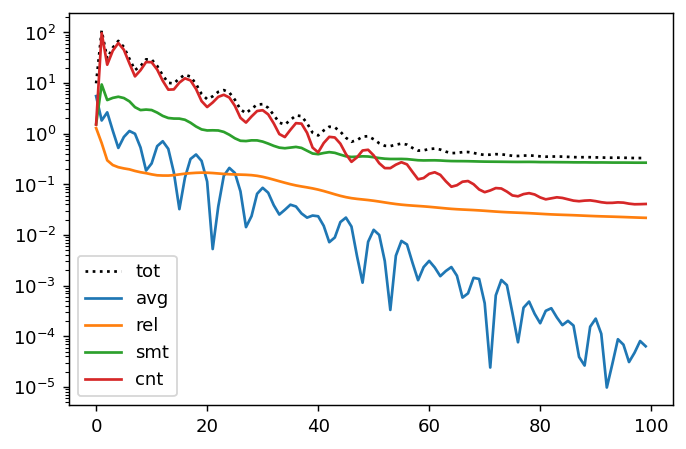

In [22]:
imgs, losses = fit(losses, smodel_recon,
    N_epochs = 100,
    lr       = 1.0e-1,
    w_avg    = 1.0e+0,
    w_rel    = 1.0e+0,
    w_smt    = 1.0e+0,
    w_cnt    = 1.0e+0,
)
smodel_recon.model_1D.save('1D_stellar_wind_recon_100.h5')
losses.plot()

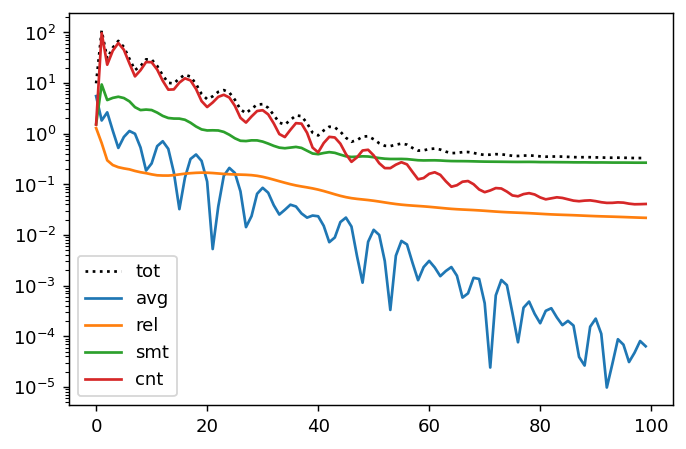

In [23]:
losses.plot()

Store the model reconstruction.

In [24]:
smodel_recon.model_1D.save('model_recon.h5')

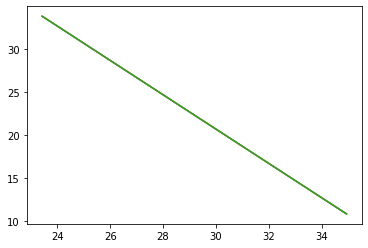

In [31]:
plt.plot(
    smodel_truth.model_1D['log_r' ].data,
    smodel_truth.model_1D['log_CO'].data,
    label='Truth'
)
plt.plot(
    smodel_recon.model_1D['log_r' ].data,
    smodel_recon.model_1D['log_CO'].data,
    label='Reconstruction'
)
plt.plot(
    smodel_recon.model_1D['log_r' ].data,
    np.log(n_CO_init),
)

In [34]:
smodel_truth.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_r                      Fixed         True     +2.343e+01     +2.919e+01     +3.494e+01
  log_CO                     Free          True     +1.082e+01     +2.233e+01     +3.385e+01
  log_turbulence             Fixed         False    +6.908e+00     +6.908e+00     +6.908e+00
  log_v_in                   Fixed         False    +4.605e+00     +4.605e+00     +4.605e+00
  log_v_inf                  Fixed         False    +9.903e+00     +9.903e+00     +9.903e+00
  log_beta                   Fixed         False    -6.931e-01     -6.931e-01     -6.931e-01
  log_epsilon                Fixed         False    -5.108e-01     -5.108e-01     -5.108e-01
  log_T_star                 Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_r_star                 Fixed         False    +2.573e+01     +2.573e+01     +2.573e+01
  log_velocity               Free          True     -4.605e+00     +6.928e+00

In [ ]:
smodel_truth.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_r                      Fixed         True     +2.343e+01     +2.919e+01     +3.494e+01
  log_CO                     Free          True     +1.082e+01     +2.233e+01     +3.385e+01
  log_turbulence             Fixed         False    +6.908e+00     +6.908e+00     +6.908e+00
  log_v_in                   Fixed         False    +4.605e+00     +4.605e+00     +4.605e+00
  log_v_inf                  Fixed         False    +9.903e+00     +9.903e+00     +9.903e+00
  log_beta                   Fixed         False    -6.931e-01     -6.931e-01     -6.931e-01
  log_epsilon                Fixed         False    -5.108e-01     -5.108e-01     -5.108e-01
  log_T_star                 Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_r_star                 Fixed         False    +2.573e+01     +2.573e+01     +2.573e+01
  log_velocity               Free          True     -4.605e+00     +6.928e+00